## Контрольная работа CVDL, 24.10.22
Вам необходимо обучить многоклассовый классификатор изображений на train части датасета, находящегося в DATASET_PATH.
Также надо проверить что обучение сошлось, и замерять метрики на test.

Баллы:
 - работающий код тренировки с правильным лоссом и головой для задачи многоклассовой классификации: **4** балла
 - метрики precision/recall по классам по train и test: **2** балла
 - график train и test лоссов: **2** балла
 - отсутствие оверфита (по графикам train-test): **2** балла

Предполагается, что вы используете предобученную модель и затюните ее. Датасеты train и тест маленькие, всего по  2500 изображений, так что обучение сети с нуля приведет скорее всего к оверфиту.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from pathlib import Path

#######
DATASET_PATH = "/content/drive/MyDrive/cvdl/GroceryStoreDataset/dataset"
#######

DATASET_PATH = Path(DATASET_PATH)
assert DATASET_PATH.exists()

In [4]:
import torch
import numpy as np
from tqdm import tqdm

In [5]:
from torchvision.datasets.folder import DatasetFolder, default_loader
from typing import Optional, Callable, Tuple, Any, List
import pandas as pd


class FoodDataset(DatasetFolder):
    def __init__(self,
            root: str,
            classes_path: str,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            ):
        super().__init__(root=root, transform=transform, loader=default_loader, target_transform=target_transform, extensions='')
        self.root = Path(root)
        self._image_paths = self.find_images_recursively(self.root)
        self._classes_map = pd.read_csv(classes_path).set_index('Class Name (str)')['Coarse Class Name (str)']
        self._image_labels = [self.determine_sample_label(self.root, ip) for ip in self._image_paths]
        self.classes = list(dict.fromkeys(self._classes_map))
        self.samples = [
            (sample_path, self.classes.index(sample_cls))
            for (sample_path, sample_cls) in zip(self._image_paths, self._image_labels)
        ]

    def find_images_recursively(self, root_path):
        files = list(root_path.glob("[!.]*"))
        samples = list(f for f in files if not f.is_dir())
        subdirs = list(f for f in files if f.is_dir())
        assert len(samples) == 0 or len(subdirs) == 0, f"Can't mix subdirs and images"
        if len(subdirs):
            samples = []
            for sub_root_path in subdirs:
                samples += self.find_images_recursively(sub_root_path)
        return samples

    def determine_sample_label(self, root_path, sample_path):
        parts = sample_path.relative_to(root_path).parent.parts
        precise_label = parts[-1]
        coarse_label = self._classes_map[precise_label]
        return coarse_label

In [6]:
ds_train = FoodDataset(DATASET_PATH / 'train', DATASET_PATH / 'classes.csv')
ds_test = FoodDataset(DATASET_PATH / 'test', DATASET_PATH / 'classes.csv')
print(len(ds_train), len(ds_test))

2640 2485


In [7]:
ds_train.classes == ds_test.classes

True

Banana


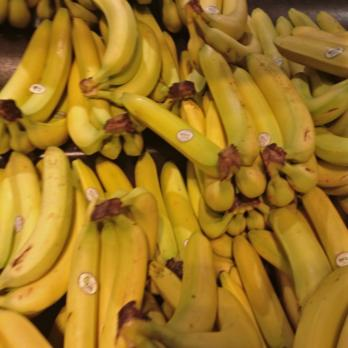

In [8]:
img, cls_idx = ds_train[750]
print(ds_train.classes[cls_idx])
img

### Подготовка к тренировке

In [9]:
N_CLASSES = len(ds_train.classes)

In [10]:
import torchvision.transforms as transforms

In [11]:
target_transform = lambda x: torch.Tensor([x]).long()[0]

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        transforms.Resize((224, 224)),
    ]
)


Трансформы можно менять - например, можно добавить аугментации

In [12]:
train_transform = test_transform

In [13]:
ds_train = FoodDataset(DATASET_PATH / 'train', DATASET_PATH / 'classes.csv', transform=train_transform, target_transform=target_transform)
ds_test = FoodDataset(DATASET_PATH / 'test', DATASET_PATH / 'classes.csv', transform=test_transform, target_transform=target_transform)

In [14]:
trainloader = torch.utils.data.DataLoader(
    ds_train, batch_size=32, shuffle=True, num_workers=4
)
testloader = torch.utils.data.DataLoader(
    ds_test, batch_size=32, shuffle=False, num_workers=4
)

### Построение модели
Используйте не слишком тяжелую pretrained-модель, заморозьте ее и добавьте голову на N классов.

Важно помнить, что для некоторых слоев поведение в train/eval режимах - разное, и от этого зависит "успешность" тюнинга.

In [15]:
import torchvision
import torch.nn as nn

In [16]:
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, N_CLASSES)
net = model

## Лосс

In [17]:
criterion = nn.CrossEntropyLoss()

## Тренировка

Для легкого backbone с замороженными весами на batch=32 скорость train ~ 10 батчей в секунду, а в эпохе ~ 80 батчей.

Тренировка в 50 эпох займет 80batch / 10batch/s * 50ep * 2 \[train + test\] = 800s ~13min

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score

class PrecisionAndRecall(nn.Module):
    def forward(self, input_prob: torch.Tensor, target: torch.Tensor):
        target = target.detach().cpu()
        input_cls = torch.argmax(input_prob, dim=1, keepdims=True).detach().cpu()

        precision = precision_score(target, input_cls, average='micro')
        recall = recall_score(target, input_cls, average='micro')

        return precision, recall

metric = PrecisionAndRecall()

In [19]:
def run_1_epoch(net, optimizer, dataloader, criterion, device=None, log_freq=10):
    loss_logs = []
    precisions = []
    recalls = []
    is_training = net.training

    for num, (x, y) in tqdm(enumerate((iter(dataloader)))):
        x, y = x.to(device), y.to(device)
        y_pred = net(x)
        loss_val = criterion(y_pred, y)
        precision, recall = metric(y_pred, y)

        if is_training:
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

        if num % log_freq == 0:
            loss_logs.append(loss_val.mean().detach().cpu().item())
            precisions.append(precision)
            recalls.append(recall)

    return np.mean(loss_logs), np.mean(precisions), np.mean(recalls)

In [20]:
def train(net, optimizer, train_dataloader, test_dataloader, criterion, num_epochs, device):
    stats = {"train": [], "val": []}
    for e in range(num_epochs):
        print(f'Epoch {e}:')
        print(f"Training:")
        net.train()
        epoch_stats = run_1_epoch(net, optimizer, train_dataloader, criterion, device, log_freq=1)
        stats["train"].append(epoch_stats)
        print(epoch_stats)

        print(f"Validating:")
        net.eval()
        epoch_stats = run_1_epoch(net, optimizer, test_dataloader, criterion, device, log_freq=1)
        stats["val"].append(epoch_stats)
        print(epoch_stats)

    return stats

In [21]:
gpu = torch.device('cuda')
net = net.to(gpu)
opt = torch.optim.Adam(net.parameters(), lr=3e-5)

In [22]:
N_epochs = 15

In [23]:
res = train(
    net=net,
    optimizer=opt,
    train_dataloader=trainloader,
    test_dataloader=testloader,
    criterion=criterion,
    num_epochs=N_epochs,
    device=gpu
)

Epoch 0:
Training:


83it [00:25,  3.32it/s]

(2.4971956632223473, 0.4115210843373494, 0.4115210843373494)
Validating:



78it [00:17,  4.36it/s]


(1.7666315940710215, 0.5833333333333334, 0.5833333333333334)
Epoch 1:
Training:


83it [00:19,  4.27it/s]

(1.116192294890622, 0.7782379518072289, 0.7782379518072289)
Validating:



78it [00:14,  5.28it/s]

(1.1918972507119179, 0.7091346153846154, 0.7091346153846154)
Epoch 2:
Training:



83it [00:17,  4.76it/s]

(0.5861530390130468, 0.9220632530120482, 0.9220632530120482)
Validating:



78it [00:15,  5.17it/s]

(0.8809269334261234, 0.7798763736263736, 0.7798763736263736)
Epoch 3:
Training:



83it [00:16,  5.02it/s]

(0.3197002385754183, 0.978539156626506, 0.978539156626506)
Validating:



78it [00:15,  4.95it/s]

(0.708048510341308, 0.832226800976801, 0.832226800976801)
Epoch 4:
Training:



83it [00:17,  4.82it/s]

(0.18685142938272062, 0.995105421686747, 0.995105421686747)
Validating:



78it [00:15,  5.15it/s]


(0.6425756550370119, 0.8406402625152626, 0.8406402625152626)
Epoch 5:
Training:


83it [00:17,  4.83it/s]

(0.12466406813227987, 0.9981174698795181, 0.9981174698795181)
Validating:



78it [00:14,  5.30it/s]

(0.5848347856543767, 0.8454479548229549, 0.8454479548229549)
Epoch 6:
Training:



83it [00:17,  4.74it/s]

(0.08348202498921428, 0.9992469879518072, 0.9992469879518072)
Validating:



78it [00:14,  5.23it/s]

(0.546843882650137, 0.8580586080586081, 0.8580586080586081)
Epoch 7:
Training:



83it [00:17,  4.81it/s]

(0.05754260328340243, 1.0, 1.0)
Validating:



78it [00:14,  5.32it/s]

(0.5287347202881788, 0.8528502747252747, 0.8528502747252747)
Epoch 8:
Training:



83it [00:16,  4.95it/s]

(0.04628429088337594, 0.9992469879518072, 0.9992469879518072)
Validating:



78it [00:14,  5.30it/s]

(0.5093347305097641, 0.8590697496947498, 0.8590697496947498)
Epoch 9:
Training:



83it [00:17,  4.86it/s]

(0.03532942286860871, 1.0, 1.0)
Validating:



78it [00:14,  5.22it/s]

(0.4964836524942747, 0.8658997252747253, 0.8658997252747253)
Epoch 10:
Training:



83it [00:23,  3.54it/s]

(0.029882235317883723, 1.0, 1.0)
Validating:



78it [00:18,  4.17it/s]

(0.4685751191125466, 0.8660905067155067, 0.8660905067155067)
Epoch 11:
Training:



83it [00:22,  3.62it/s]

(0.025161142561988658, 1.0, 1.0)
Validating:



78it [00:14,  5.28it/s]

(0.4483468257463895, 0.8714896214896216, 0.8714896214896216)
Epoch 12:
Training:



83it [00:16,  4.90it/s]

(0.021415811043277562, 1.0, 1.0)
Validating:



78it [00:15,  5.09it/s]

(0.47455397262596166, 0.863476800976801, 0.863476800976801)
Epoch 13:
Training:



83it [00:17,  4.77it/s]

(0.018844533902424646, 1.0, 1.0)
Validating:



78it [00:15,  5.19it/s]


(0.46614463825542957, 0.8650793650793651, 0.8650793650793651)
Epoch 14:
Training:


83it [00:18,  4.61it/s]

(0.017039503879755377, 1.0, 1.0)
Validating:



78it [00:15,  4.88it/s]

(0.43888448839051986, 0.8718902625152626, 0.8718902625152626)


In [24]:
train_logs = res['train']
train_loss = [i[0] for i in train_logs]
train_precision = [i[1] for i in train_logs]
train_recall = [i[2] for i in train_logs]

val_logs = res['val']
val_loss = [i[0] for i in val_logs]
val_precision = [i[1] for i in val_logs]
val_recall = [i[2] for i in val_logs]

## Метрики и лосс

In [25]:
net.eval()
train_stats = run_1_epoch(net, opt, trainloader, criterion, gpu)
train_stats

83it [00:15,  5.26it/s]


(0.0030399160200936925, 1.0, 1.0)

In [26]:
net.eval()
test_stats = run_1_epoch(net, opt, testloader, criterion, gpu)
test_stats

78it [00:14,  5.21it/s]


(0.42458803625777364, 0.87109375, 0.87109375)

In [27]:
print(f"Train Precision/Recall: {[train_stats[1], train_stats[2]]}, \nTest Precision/Recall {[test_stats[1], test_stats[2]]}")

Train Precision/Recall: [1.0, 1.0], 
Test Precision/Recall [0.87109375, 0.87109375]


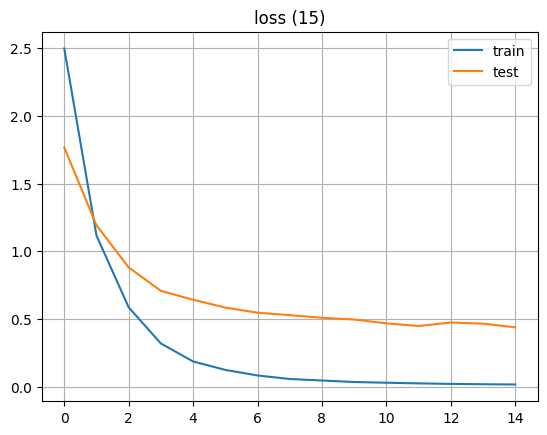

In [28]:
from matplotlib import pyplot as plt

plt.plot(np.arange(len(train_loss)), train_loss, label='train')
plt.plot(np.arange(len(val_loss)), val_loss, label='test')

plt.title(f'loss ({N_epochs} epochs)')
plt.grid()
plt.legend()

### Окружение
Список пакетов в python виртуальной машины

In [29]:
! nvidia-smi

Tue Oct 17 14:37:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    30W /  70W |   1953MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [30]:
! cat /etc/lsb-release

DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=22.04
DISTRIB_CODENAME=jammy
DISTRIB_DESCRIPTION="Ubuntu 22.04.2 LTS"


In [31]:
! python -V

Python 3.10.12


In [32]:
! pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.8.6
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.4.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
attrs                            23.1.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.13.0
backcall                         0.2.0
beautifulsoup4                   4.11.2
bleach                           6.1.0
blinker                          1.4
bl